# ECE 276C HW3 P1
Mingwei Xu A53270271

In [13]:
import gym
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import Categorical

## Define Network

In [14]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0]
        self.action_space_n = env.action_space.n

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 64)
        self.dropout = nn.Dropout(p=0.6)
        self.l2 = nn.Linear(64, self.action_space_n)

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # build neural network
        network = nn.Sequential(
            self.l1,
            self.dropout,
            self.l2,
            nn.Softmax(dim=-1))
        return network(torch.FloatTensor(x))

## Setup

In [15]:
env = gym.make('CartPole-v1')
state = env.reset()
policy_network = PolicyNetwork(env)
policy_network.forward(state)   # TODO: test
policy_network.parameters()

<generator object Module.parameters at 0x123bcbde0>

## Choose Action

In [16]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: int, action; tensor, log probability
    """
    probs = policy_network.forward(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

In [17]:
choose_action(policy_network, state)    # TODO: test

(1, tensor(-1.1153, grad_fn=<SqueezeBackward1>))

## Question 1

In [19]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    """
    # TODO: setup place holders
    batch_loss_sum = 0  # sum of batch loss over episodes
    step_over_episode = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders
        batch_states = []
        batch_actions = []
        batch_rewards = []
        log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        for step in range(batch_size):
            # step
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            batch_states.append(state)
            batch_actions.append(action)
            batch_rewards.append(reward)
            log_prob_list.append(log_prob)

            # move on
            if done:
                break   # TODO
                state = env.reset()
            else:
                state = state_next

        # finish batch
        batch_log_prob_sum = sum(log_prob_list)     # log likelihood sum, this is tensor
        batch_discounted_return = sum(torch.FloatTensor(np.array(batch_rewards) *
                                                        np.array([gamma ** t for t in range(1, len(batch_rewards) + 1)])))  # G(t), this is tensor
        batch_loss = batch_discounted_return * batch_log_prob_sum   # calculate batch loss
        batch_loss_sum += batch_loss    # update batch loss sum over episodes
        loss = batch_loss_sum / (i + 1)
        print('Episode {} loss: {}, steps: {}, average reward: {}'.format(i, loss.item(), step, np.mean(batch_rewards)))
        step_over_episode.append(step)

        # update policy
        loss.backward(retain_graph=True)
        optimizer.zero_grad()
        optimizer.step()
        

    return step_over_episode

In [20]:
step_over_episode = reinforce(env, policy_network, batch_size=500, num_episodes=200, gamma=0.99)

Episode 0 loss: -240.6743927001953, steps: 20, average reward: 1.0
Episode 1 loss: -158.9751434326172, steps: 10, average reward: 1.0
Episode 2 loss: -127.90576934814453, steps: 10, average reward: 1.0
Episode 3 loss: -296.1290283203125, steps: 36, average reward: 1.0
Episode 4 loss: -379.474609375, steps: 34, average reward: 1.0
Episode 5 loss: -407.3179016113281, steps: 29, average reward: 1.0
Episode 6 loss: -357.07940673828125, steps: 9, average reward: 1.0
Episode 7 loss: -326.14404296875, steps: 12, average reward: 1.0
Episode 8 loss: -300.9676513671875, steps: 14, average reward: 1.0
Episode 9 loss: -291.8220520019531, steps: 19, average reward: 1.0
Episode 10 loss: -280.8577575683594, steps: 16, average reward: 1.0
Episode 11 loss: -416.5041198730469, steps: 61, average reward: 1.0
Episode 12 loss: -411.2362976074219, steps: 23, average reward: 1.0
Episode 13 loss: -475.2373046875, steps: 49, average reward: 1.0
Episode 14 loss: -456.2704162597656, steps: 16, average reward: 1.

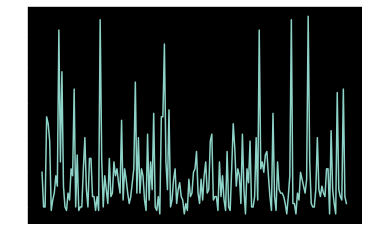

In [22]:
%matplotlib inline
plt.figure()
plt.plot(step_over_episode)
plt.show()